# Assignment 1 Group XX



## Question 1

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, jarque_bera, kstest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from portfolio import Portfolio_Optimizer
from pfolioutils import evaluate_strategies, plot_weight_matrices
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
index_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='indices',index_col='date')
fx_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='currencies',index_col='date')
weight_df = pd.read_excel('PS1_data_clean.xlsx', sheet_name='market_cap')

index_df.head()

,SPTSX INDEX,CAC INDEX,DAX INDEX,SX5E INDEX,NKY INDEX,UKX INDEX,SPX INDEX,IBOV INDEX
date,,,,,,,,
03/30/2007,13165.500000,5634.160156,6917.029785,4181.029785,17287.650391,6308.03,1420.86,45805
04/02/2007,13265.799805,5645.560059,6937.169922,4189.549805,17028.410156,6315.53,1424.55,45597
04/03/2007,13361.200195,5711.910156,7045.560059,4246.299805,17244.050781,6366.11,1437.77,46288
04/04/2007,13448.299805,5739.009766,7073.910156,4261.830078,17544.089844,6364.70,1439.37,46554
04/05/2007,13425.000000,5741.379883,7099.910156,4271.540039,17491.419922,6397.34,1443.76,46647


In [3]:
# convert to dollar
for index in index_df.columns:
    curr = weight_df[weight_df['Ticker'] == index]['Currency'].to_string()[-3:]
    index_df[index] = index_df[index]*fx_df[curr]

In [4]:
logreturns_df = np.log(index_df) - np.log(index_df.shift(1))
logreturns_df = logreturns_df.dropna()

mean_values = logreturns_df.mean()
std_deviation = logreturns_df.std()
kurtosis_values = logreturns_df.kurtosis()
skewness_values = logreturns_df.skew()

statistics_table = pd.DataFrame({
    'Mean': mean_values,
    'Standard Deviation': std_deviation,
    'Kurtosis': kurtosis_values,
    'Skewness': skewness_values
})

statistics_table

,Mean,Standard Deviation,Kurtosis,Skewness
SPTSX INDEX,0.000117,0.015251,12.306159,-0.866287
CAC INDEX,0.000025,0.018352,17.583211,0.372231
DAX INDEX,0.000207,0.018058,16.916223,0.410990
SX5E INDEX,-0.000041,0.018481,16.980611,0.283744
NKY INDEX,0.000165,0.016163,16.738605,-0.552431
UKX INDEX,-0.000065,0.015374,10.097418,-0.274447
SPX INDEX,0.000374,0.013581,12.021852,-0.637743
IBOV INDEX,-0.000060,0.024794,11.078068,-0.154794


In [5]:
logreturns_df.corr()


,SPTSX INDEX,CAC INDEX,DAX INDEX,SX5E INDEX,NKY INDEX,UKX INDEX,SPX INDEX,IBOV INDEX
SPTSX INDEX,1.000000,0.677227,0.659697,0.661918,0.222340,0.716389,0.771410,0.685627
CAC INDEX,0.677227,1.000000,0.950523,0.984838,0.260700,0.841713,0.612419,0.567331
DAX INDEX,0.659697,0.950523,1.000000,0.966589,0.246152,0.809851,0.615929,0.540996
SX5E INDEX,0.661918,0.984838,0.966589,1.000000,0.248228,0.830241,0.611192,0.553301
NKY INDEX,0.222340,0.260700,0.246152,0.248228,1.000000,0.343642,0.099309,0.238317
UKX INDEX,0.716389,0.841713,0.809851,0.830241,0.343642,1.000000,0.616687,0.617852
SPX INDEX,0.771410,0.612419,0.615929,0.611192,0.099309,0.616687,1.000000,0.610080
IBOV INDEX,0.685627,0.567331,0.540996,0.553301,0.238317,0.617852,0.610080,1.000000


In [6]:

for col in logreturns_df.columns:
    jarque_bera_statistic, jarque_bera_p_value = jarque_bera(logreturns_df[col])
    print(f'Jarque-Bera test p-value for {col}: {jarque_bera_p_value}')

Jarque-Bera test p-value for SPTSX INDEX: 0.0
Jarque-Bera test p-value for CAC INDEX: 0.0
Jarque-Bera test p-value for DAX INDEX: 0.0
Jarque-Bera test p-value for SX5E INDEX: 0.0
Jarque-Bera test p-value for NKY INDEX: 0.0
Jarque-Bera test p-value for UKX INDEX: 0.0
Jarque-Bera test p-value for SPX INDEX: 0.0
Jarque-Bera test p-value for IBOV INDEX: 0.0


In [7]:
for col in logreturns_df.columns:
    ks_statistic, ks_p_value = kstest(logreturns_df[col], 'norm')
    print(f'Kolmogorov-Smirnov test p-value for {col}: {ks_p_value}')

Kolmogorov-Smirnov test p-value for SPTSX INDEX: 0.0
Kolmogorov-Smirnov test p-value for CAC INDEX: 0.0
Kolmogorov-Smirnov test p-value for DAX INDEX: 0.0
Kolmogorov-Smirnov test p-value for SX5E INDEX: 0.0
Kolmogorov-Smirnov test p-value for NKY INDEX: 0.0
Kolmogorov-Smirnov test p-value for UKX INDEX: 0.0
Kolmogorov-Smirnov test p-value for SPX INDEX: 0.0
Kolmogorov-Smirnov test p-value for IBOV INDEX: 0.0


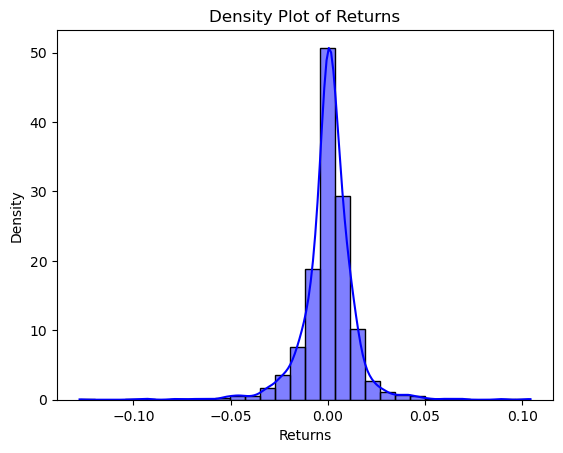

In [8]:
# Assuming 'returns_df' is already defined from your previous code
returns_column = logreturns_df['SPX INDEX']  # Replace 'YourColumnName' with the actual column name

# Plot the density
sns.histplot(returns_column, kde=True, bins=30, color='blue', stat='density')
plt.title('Density Plot of Returns')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.show()


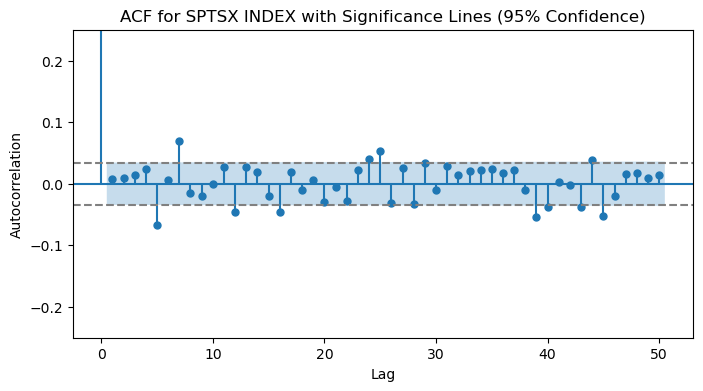

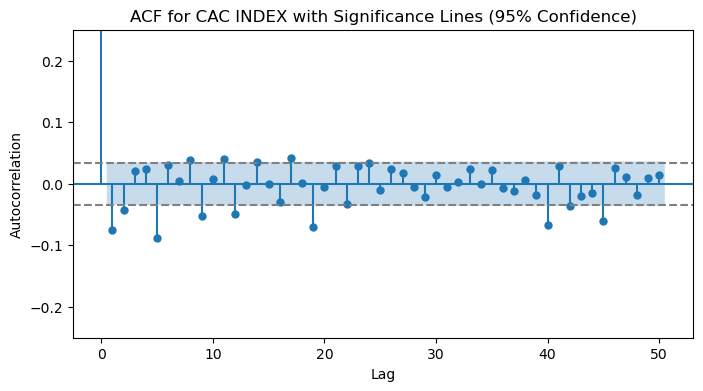

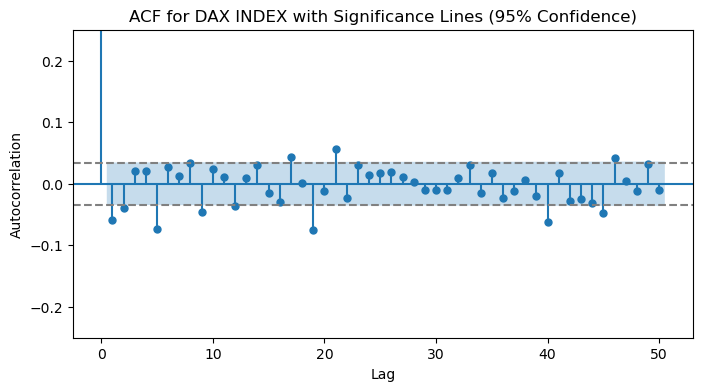

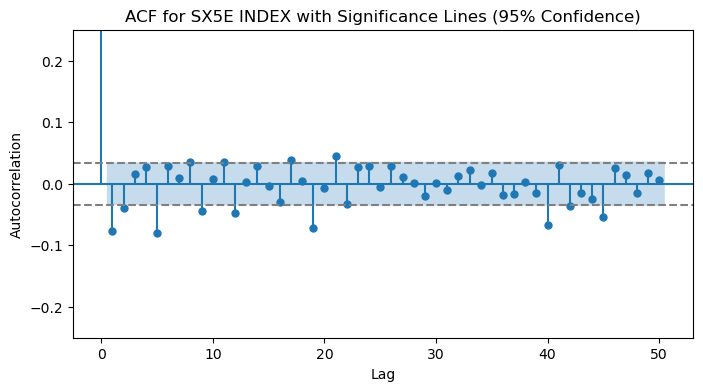

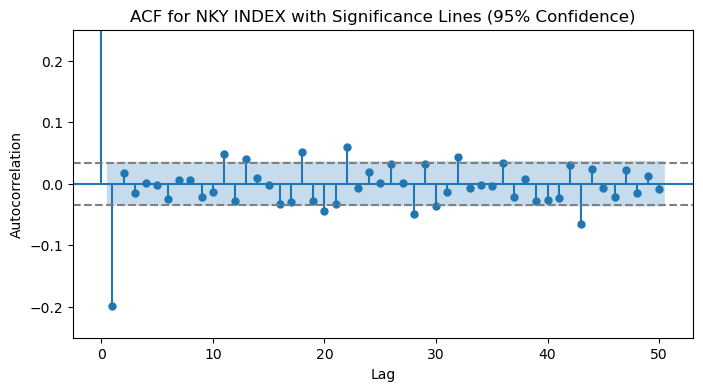

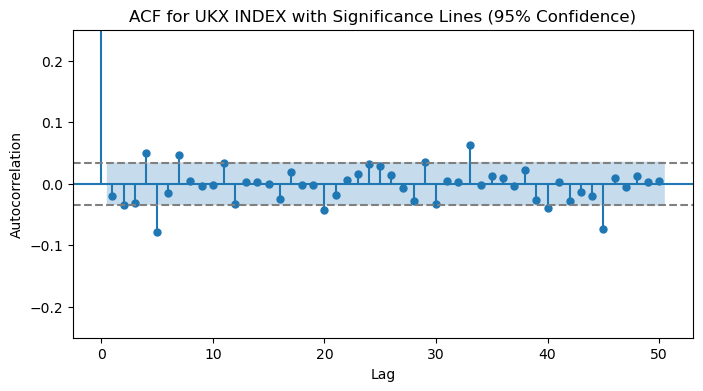

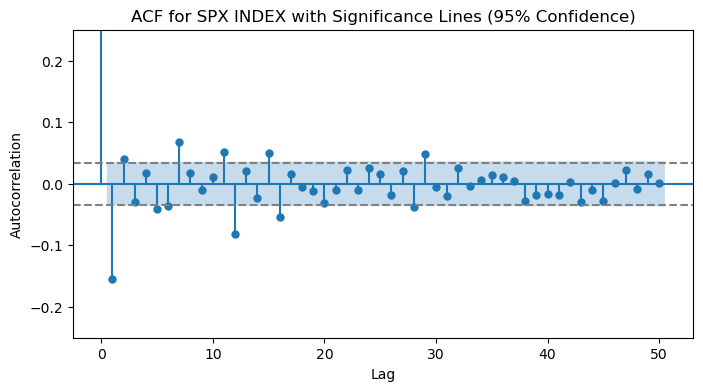

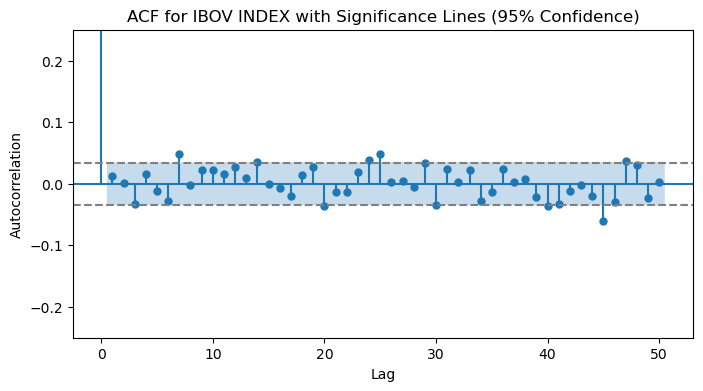

In [9]:
confidence_level = 0.95
num_lags = 50

for col in logreturns_df.columns:
    series = logreturns_df[col].dropna()
    
    # Calculate autocorrelation values
    acf_values = acf(series, fft=True, nlags=num_lags)
    
    # Plot ACF with significance lines
    fig, ax = plt.subplots(figsize=(8, 4))
    plot_acf(series, lags=num_lags, ax=ax, alpha=0.05)
    
    # Add significance lines
    critical_value = 1.96 / (len(series) ** 0.5)  # 95% confidence interval
    ax.axhline(y=critical_value, linestyle='--', color='gray')
    ax.axhline(y=-critical_value, linestyle='--', color='gray')
    
    plt.ylim([-0.25, 0.25])
    plt.title(f'ACF for {col} with Significance Lines (95% Confidence)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

## Question 2 

### Long Short Scenario

In [10]:
returns_df = index_df.pct_change().dropna()

ls_portfolio = Portfolio_Optimizer(returns_df, short=True)

In [11]:
market_cap_weights = np.array(weight_df['MktCap%'])

custom_weigths = {
    'Mkt Cap Weighted Portfolio': market_cap_weights
}

ls_portfolio.performance_summary(custom_weights=custom_weigths)

Max Sharpe Portfolio:
   - Return: 0.2042542906303695
   - Standard Deviation (Risk): 0.2073217359400867
   - Sharpe Ratio: 0.9852044200970628

Min Variance Portfolio:
   - Return: 0.09243536876523031
   - Standard Deviation (Risk): 0.16582570142434142
   - Sharpe Ratio: 0.557424862197277

Equal Weight Portfolio:
   - Return: 0.06216202345229385
   - Standard Deviation (Risk): 0.22268786570377302
   - Sharpe Ratio: 0.279144188013297

Mkt Cap Weighted Portfolio:
   - Return: 0.08969246261501455
   - Standard Deviation (Risk): 0.19599724489887774
   - Sharpe Ratio: 0.4576210377920885


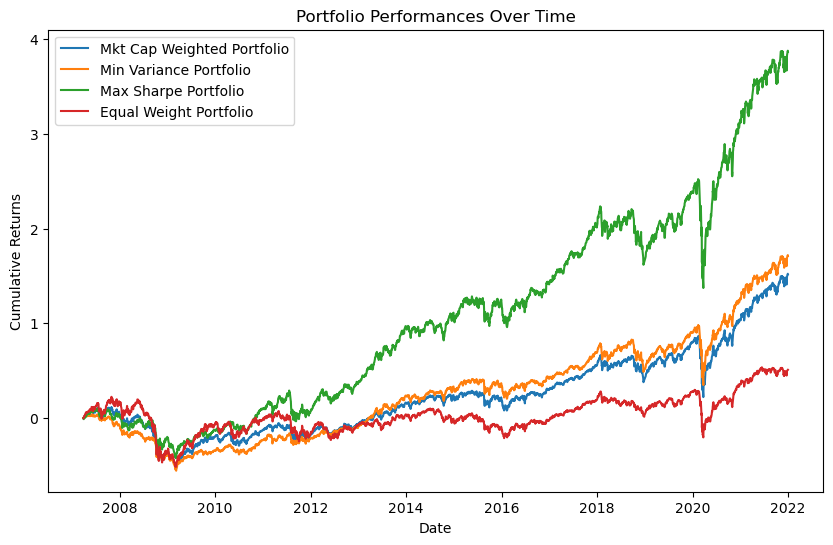

In [12]:
ls_portfolio.plot_performance(index_df, custom_weights=custom_weigths)

In [13]:
ls_portfolio.print_all_weights()

       Indices  Min Variance Portfolio Weights  Max Sharpe Portfolio Weights
0  SPTSX INDEX                        0.082040                     -0.097202
1    CAC INDEX                       -0.104296                      0.226909
2    DAX INDEX                        0.050929                      1.000000
3   SX5E INDEX                       -0.037376                     -1.000000
4    NKY INDEX                        0.372525                      0.478015
5    UKX INDEX                        0.197199                     -0.508645
6    SPX INDEX                        0.583003                      1.000000
7   IBOV INDEX                       -0.144024                     -0.099077


### Long Only Scenario

In [14]:
returns_df = index_df.pct_change().dropna()

portfolio = Portfolio_Optimizer(returns_df)

In [15]:
market_cap_weights = np.array(weight_df['MktCap%'])

custom_weigths = {
    'Mkt Cap Weighted Portfolio': market_cap_weights
}

portfolio.performance_summary(custom_weights=custom_weigths)


Max Sharpe Portfolio:
   - Return: 0.10479054925991783
   - Standard Deviation (Risk): 0.17650261073944815
   - Sharpe Ratio: 0.593705378186212

Min Variance Portfolio:
   - Return: 0.09390923670506174
   - Standard Deviation (Risk): 0.1714903805307943
   - Sharpe Ratio: 0.5476064395821816

Equal Weight Portfolio:
   - Return: 0.06216202345229385
   - Standard Deviation (Risk): 0.22268786570377302
   - Sharpe Ratio: 0.279144188013297

Mkt Cap Weighted Portfolio:
   - Return: 0.08969246261501455
   - Standard Deviation (Risk): 0.19599724489887774
   - Sharpe Ratio: 0.4576210377920885


In [16]:
portfolio.print_all_weights()

       Indices  Min Variance Portfolio Weights  Max Sharpe Portfolio Weights
0  SPTSX INDEX                    2.622875e-17                  0.000000e+00
1    CAC INDEX                    2.971104e-17                  0.000000e+00
2    DAX INDEX                    0.000000e+00                  0.000000e+00
3   SX5E INDEX                    1.151446e-18                  0.000000e+00
4    NKY INDEX                    3.875035e-01                  2.761847e-01
5    UKX INDEX                    5.928625e-02                  2.949357e-16
6    SPX INDEX                    5.532103e-01                  7.238153e-01
7   IBOV INDEX                    0.000000e+00                  0.000000e+00


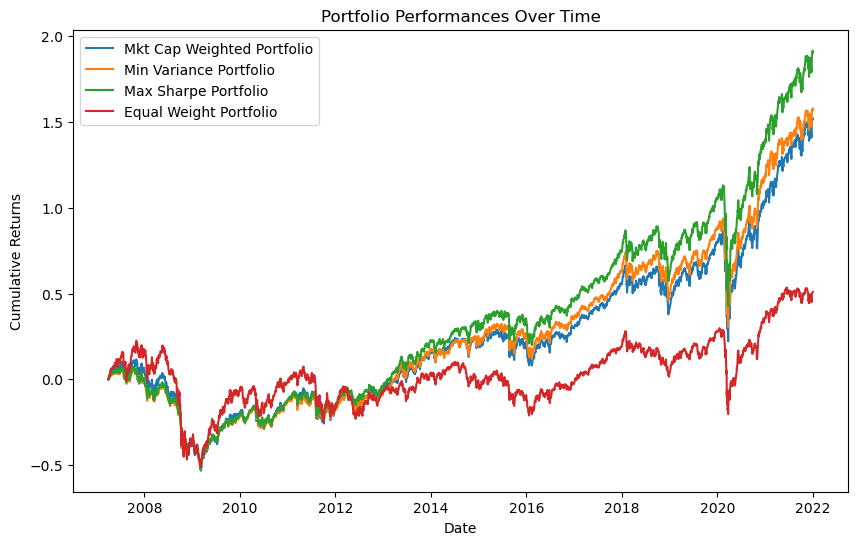

In [17]:
portfolio.plot_performance(index_df, custom_weights=custom_weigths)

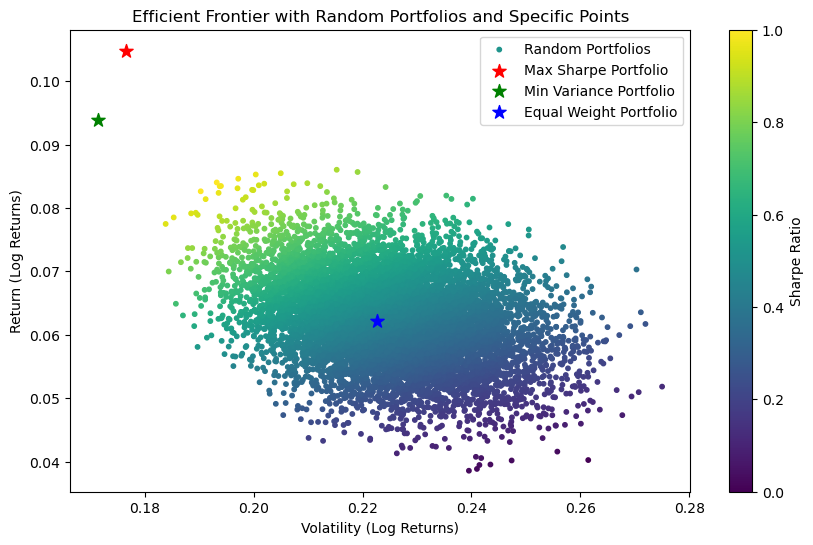

In [18]:
portfolio.plot_efficient_frontier(10000)


In [19]:
portfolio.print_all_weights()

       Indices  Min Variance Portfolio Weights  Max Sharpe Portfolio Weights
0  SPTSX INDEX                    2.622875e-17                  0.000000e+00
1    CAC INDEX                    2.971104e-17                  0.000000e+00
2    DAX INDEX                    0.000000e+00                  0.000000e+00
3   SX5E INDEX                    1.151446e-18                  0.000000e+00
4    NKY INDEX                    3.875035e-01                  2.761847e-01
5    UKX INDEX                    5.928625e-02                  2.949357e-16
6    SPX INDEX                    5.532103e-01                  7.238153e-01
7   IBOV INDEX                    0.000000e+00                  0.000000e+00


## Question 3

In [20]:
rw_returns_df = returns_df.loc['01/04/2008':]


rw_returns_df.index = pd.to_datetime(rw_returns_df.index)
index_df.index = pd.to_datetime(index_df.index)


# Initialize empty DataFrames to store performance values
min_var_df = pd.DataFrame(index=rw_returns_df.index, columns=['Min_Var_Sharpe_performance'])
max_sharpe_df = pd.DataFrame(index=rw_returns_df.index, columns=['Max_Sharpe_performance'])
mkt_cap_df = pd.DataFrame(index=rw_returns_df.index, columns=['Mkt_Cap_performance'])

min_var_weights_df = []
max_sharpe_weights_df = []
mkt_cap_weights_df = []

# Iterate through each rolling window
for year_start in range(2012, 2022):  # Adjust the start year accordingly
    # Define the start and end dates for the current window
    start_date = rw_returns_df.index[rw_returns_df.index.year == year_start - 4].min()
    end_date = rw_returns_df.index[rw_returns_df.index.year == year_start].max()

    # Extract the data for the previous 5 years
    prev_window_data = rw_returns_df.loc[start_date:end_date]

    # Calculate weights for the previous 5 years
    tmp_portfolio = Portfolio_Optimizer(prev_window_data)

    min_var_weights = tmp_portfolio.min_variance_weights
    min_var_weights_df.append(min_var_weights)
    
    max_sharpe_weights = tmp_portfolio.max_sharpe_weights
    max_sharpe_weights_df.append(max_sharpe_weights)


    mkt_cap_weights_df.append(np.array(weight_df['MktCap%'])
)

    # Extract the data for the current year
    current_window_data = rw_returns_df.loc[start_date:end_date]

    # Calculate performance for the current year and store in DataFrames
    min_var_df.loc[start_date:end_date, 'Min_Var_Sharpe_performance'] = np.dot(current_window_data, min_var_weights)
    max_sharpe_df.loc[start_date:end_date, 'Max_Sharpe_performance'] = np.dot(current_window_data, max_sharpe_weights)
    mkt_cap_df.loc[start_date:end_date, 'Mkt_Cap_performance'] = np.dot(current_window_data, market_cap_weights)


# Optionally, concatenate the DataFrames horizontally if needed
portfolio_data = pd.concat([max_sharpe_df, min_var_df, mkt_cap_df], axis=1)

# Filter data from 2013 onwards
portfolio_data = portfolio_data.loc['2013':]


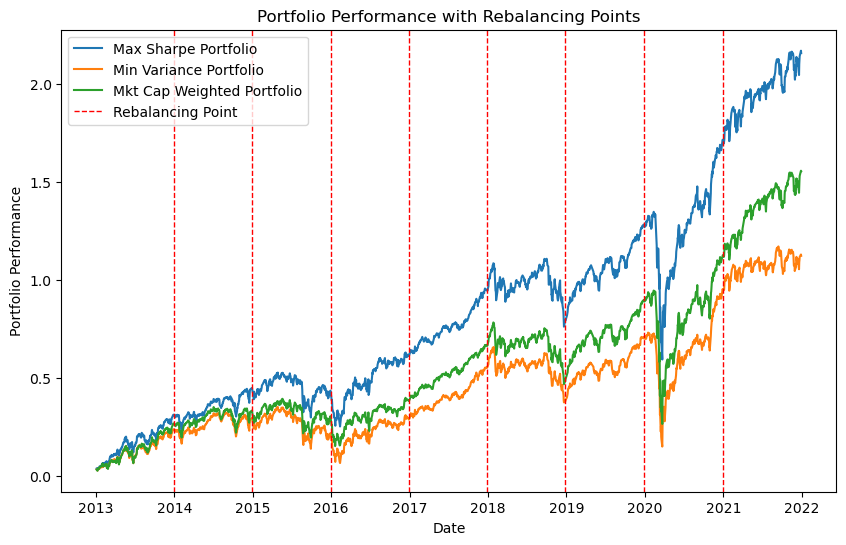

In [21]:
performance_df = (1+ portfolio_data).cumprod() -1

# Plot portfolio performance
plt.figure(figsize=(10, 6))
plt.plot(performance_df['Max_Sharpe_performance'], label='Max Sharpe Portfolio')
plt.plot(performance_df['Min_Var_Sharpe_performance'], label='Min Variance Portfolio')
plt.plot(performance_df['Mkt_Cap_performance'], label='Mkt Cap Weighted Portfolio')

# Highlight each rebalancing point
for year_start in range(2013, rw_returns_df.index.year.max()):
    rebalancing_date = rw_returns_df.index[rw_returns_df.index.year == year_start].max()
    plt.axvline(rebalancing_date, color='red', linestyle='--', linewidth=1, label='Rebalancing Point' if year_start == 2013 else '')

plt.title('Portfolio Performance with Rebalancing Points')
plt.xlabel('Date')
plt.ylabel('Portfolio Performance')
plt.legend()
plt.show()

In [22]:
portfolio_data.head()

,Max_Sharpe_performance,Min_Var_Sharpe_performance,Mkt_Cap_performance
date,,,
2013-01-04,0.040057,0.035278,0.034216
2013-01-07,-0.004937,-0.004307,-0.0041
2013-01-08,-0.002293,-0.001344,-0.001252
2013-01-09,0.004152,0.003554,0.00316
2013-01-10,0.004947,0.004397,0.003354


In [23]:

evaluate_strategies(portfolio_data)

Max Sharpe Portfolio:
   - Return: 0.1560708086137217
   - Standard Deviation (Risk): 0.15119449787598607
   - Sharpe Ratio: 1.0322519060299093

Min Variance Portfolio:
   - Return: 0.10480947812444982
   - Standard Deviation (Risk): 0.14168107079057468
   - Sharpe Ratio: 0.739756394694204

Mkt Cap Weight Portfolio:
   - Return: 0.13030345484269548
   - Standard Deviation (Risk): 0.1564443444835839
   - Sharpe Ratio: 0.8329061384278327


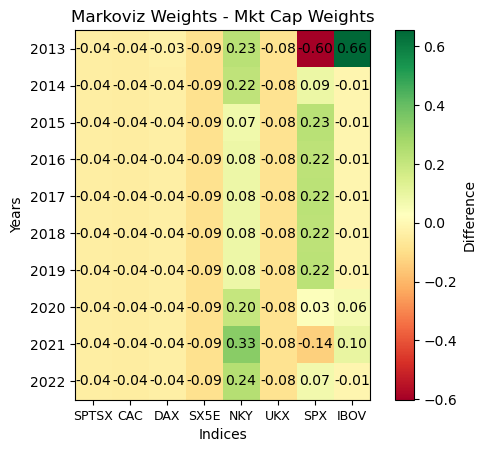

In [24]:
max_sharpe_matrix = np.array(max_sharpe_weights_df)
mkt_cap_matrix = np.array(mkt_cap_weights_df)

# Calculate the difference matrix
difference_matrix = max_sharpe_matrix - mkt_cap_matrix

plot_weight_matrices(difference_matrix, returns_df.columns, 'Markoviz Weights - Mkt Cap Weights')

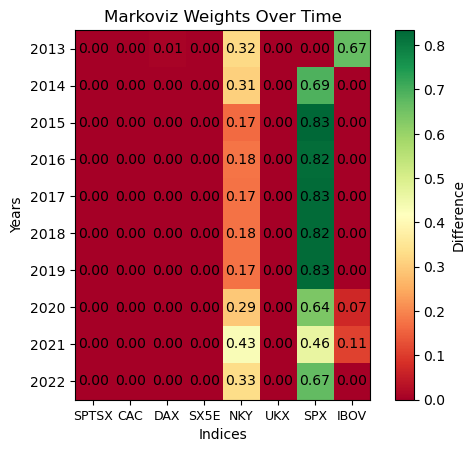

In [25]:
plot_weight_matrices(max_sharpe_matrix, returns_df.columns, 'Markoviz Weights Over Time')